In [ ]:
import pandas as pd
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Load dataset
df = pd.read_csv(r"your_path")
df = df.dropna(subset=["comment"
"", "author_name"])

# Lowercase all text
df["comment"] = df["comment"].astype(str).str.lower()

# Define spam keywords and phrases
spam_keywords = [
    "subscribe", "promocode", "free money", "check my channel", "vs mention", "href",
    "happy new year", "anyone here", "who is here", "2018", "br", "world population",
    "8 billion", "views", "anyone", "still watching", "song", "red_heart", "love",
    "its", "listening", "viewed", "billion", "world", "read", "reading", "reads",
    "population", "bilion", "sex", "gay", "porn", "pornhub", "cancer", "hot girl",
    "brbr", "brbrbr", "fuck", "shit", "4b", "3b", "1b", "2", "5b", "6b", "7b", "8b",
    "who39s", "channel", "sub", "suscribe", "million", "milon", "subs", "dislikes",
    "disslike", "die", "kill", "dead", "suicide", "birthday", "sexy","bil","ass",
]

# Regex patterns
repeat_letters = re.compile(r'(.)\1{3,}')       # 4+ repeated letters
repeat_words = re.compile(r'\b(\w+)\s+\1\b')    # repeated word (e.g., "good good")
repeat_sentences = re.compile(r'(.+?)\.\s+\1\.')  # repeated sentence (e.g., "nice. nice.")

# Function to check if text is English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Cleaning function
def clean_text(text):
    # Remove spam-like content
    if any(spam in text for spam in spam_keywords):
        return None
    if repeat_letters.search(text) or repeat_words.search(text) or repeat_sentences.search(text):
        return None
    if len(text.strip()) < 3:
        return None
    if not is_english(text):
        return None
    return text

# Apply cleaning
df["cleaned_text"] = df["comment"].apply(clean_text)
df = df.dropna(subset=["cleaned_text"])

# Deduplicate per user
unique_comments = df.drop_duplicates(subset=["author_name"], keep="first")
duplicate_users = df[df.duplicated(subset=["author_name"], keep=False)]
multi_comments = duplicate_users.groupby("author_name").filter(lambda x: x["cleaned_text"].nunique() > 1)

# Save cleaned outputs
unique_comments[["author_name", "cleaned_text"]].to_csv("cleaned_unique_comments.csv", index=False)
multi_comments[["author_name", "cleaned_text"]].to_csv("multiple_different_comments_per_user.csv", index=False)

print(f"[INFO] Cleaned {len(df)} comments.")
print(f"[INFO] Saved {len(unique_comments)} unique user comments to 'cleaned_unique_comments.csv'.")
print(f"[INFO] Saved {len(multi_comments)} multi-comment users to 'multiple_different_comments_per_user.csv'.")


[INFO] Cleaned 198935 comments.
[INFO] Saved 179261 unique user comments to 'cleaned_unique_comments.csv'.
[INFO] Saved 30477 multi-comment users to 'multiple_different_comments_per_user.csv'.


In [ ]:
import pandas as pd

# Load previously cleaned dataset
df = pd.read_csv("cleaned_unique_comments.csv")

# Spam keywords list (normalized to lowercase for comparison)
spam_keywords = [
    "subscribe", "promocode", "free money", "check my channel", "vs mention", "href",
    "happy new year", "anyone here", "who is here", "2018", "br", "world population",
    "8 billion", "views", "anyone", "still watching", "song", "red_heart", "love",
    "its", "listening", "viewed", "billion", "world", "read", "reading", "reads",
    "population", "bilion", "sex", "gay", "porn", "pornhub", "cancer", "hot girl",
    "brbr", "brbrbr", "fuck", "shit", "4b", "3b", "1b", "2", "5b", "6b", "7b", "8b",
    "who39s", "channel", "sub", "suscribe", "million", "milon", "subs", "dislikes",
    "disslike", "die", "kill", "dead", "suicide", "birthday", "sexy","merry", "merry christmas","christmas"
]

# Make all text lowercase for consistent matching
df["cleaned_text"] = df["cleaned_text"].astype(str).str.lower()

# Remove rows that contain any of the spam keywords
filtered_df = df[~df["cleaned_text"].apply(lambda x: any(keyword in x for keyword in spam_keywords))]

# Save the newly filtered dataset
filtered_df.to_csv("cleaned_unique_comments_keyword_filtered.csv", index=False)

print(f"[INFO] Filtered dataset contains {len(filtered_df)} comments after keyword-based cleaning.")


[INFO] Filtered dataset contains 67771 comments after keyword-based cleaning.


In [6]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import os

# Load dataset
df = pd.read_csv(r"C:\Users\c-x-h\OneDrive\Masaüstü\No_emoji_despa\cleaned_unique_comments.csv")
texts = df["cleaned_text"].tolist()

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Low granularity BERTopic
low_topic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=1000,  # large cluster size = fewer topics
    nr_topics=20,         # reduce to 20 topics
    calculate_probabilities=True,
    verbose=True
)

low_topics, _ = low_topic_model.fit_transform(texts)

# Save visualization
os.makedirs("low_granularity_results", exist_ok=True)
low_topic_model.visualize_topics().write_html("low_granularity_results/low_granularity_topics.html")


2025-04-09 17:07:53,653 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5602 [00:00<?, ?it/s]

2025-04-09 17:19:07,833 - BERTopic - Embedding - Completed ✓
2025-04-09 17:19:07,834 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-09 17:21:13,876 - BERTopic - Dimensionality - Completed ✓
2025-04-09 17:21:13,890 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-09 17:23:54,435 - BERTopic - Cluster - Completed ✓
2025-04-09 17:23:54,453 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-09 17:23:55,718 - BERTopic - Representation - Completed ✓
2025-04-09 17:23:55,718 - BERTopic - Topic reduction - Reducing number of topics
2025-04-09 17:23:55,718 - BERTopic - Topic reduction - Reduced number of topics from 14 to 14


In [7]:
# High granularity BERTopic
high_topic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=100,   # smaller cluster size = more topics
    nr_topics=None,       # no reduction
    calculate_probabilities=True,
    verbose=True
)

high_topics, _ = high_topic_model.fit_transform(texts)

# Save visualization
os.makedirs("high_granularity_results", exist_ok=True)
high_topic_model.visualize_topics().write_html("high_granularity_results/high_granularity_topics.html")


2025-04-09 17:24:00,767 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5602 [00:00<?, ?it/s]

2025-04-09 17:35:27,756 - BERTopic - Embedding - Completed ✓
2025-04-09 17:35:27,756 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-09 17:37:19,595 - BERTopic - Dimensionality - Completed ✓
2025-04-09 17:37:19,610 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-09 17:54:30,783 - BERTopic - Cluster - Completed ✓
2025-04-09 17:54:30,818 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-09 17:54:32,180 - BERTopic - Representation - Completed ✓


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import os

# 1. Veri Kümesini Yükle
df = pd.read_csv(r"C:\Users\c-x-h\OneDrive\Masaüstü\No_emoji_despa\cleaned_unique_comments_keyword_filtered.csv")
texts = df["cleaned_text"].astype(str).tolist()

# 2. Gömme Modelini Yükle
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# 3. Çıktı klasörünü oluştur
output_dir = "mid_granularity_output"
os.makedirs(output_dir, exist_ok=True)

# 4. BERTopic Modelini Tanımla (orta granülerlik)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=50,  # Orta ölçekli konular
    nr_topics=None,     # Otomatik konu sayısı
    verbose=True
)

# 5. Modeli Eğit ve Konuları Al
topics, probs = topic_model.fit_transform(texts)

# 6. Yorumlar ve Konularla Sonuçları Kaydet
df_result = pd.DataFrame({
    "Document": texts,
    "Topic": topics,
    "Probability": probs
})
df_result.to_csv(os.path.join(output_dir, "bertopic_mid_results.csv"), index=False)

# 7. Konu Başlıklarını Kaydet
topic_info = topic_model.get_topic_info()
topic_info.to_csv(os.path.join(output_dir, "bertopic_mid_topics.csv"), index=False)

# 8. HTML Görselleştirme
fig = topic_model.visualize_topics()
fig.write_html(os.path.join(output_dir, "bertopic_mid_visualization.html"))

print("[INFO] BERTopic modellemesi tamamlandı ve sonuçlar kaydedildi.")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# ---- LOW GRANULARITY MODEL ---- #
vectorizer_model_low = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model_low = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model_low,
    min_topic_size=100,
    nr_topics="auto",
    verbose=True
)
topics_low, probs_low = topic_model_low.fit_transform(texts)

# Save results
df_low = pd.DataFrame({
    "Document": texts,
    "Topic": topics_low,
    "Probability": probs_low
})
df_low.to_csv("low_granularity_output/bertopic_low_results.csv", index=False)

# Save topic info
topics_info_low = topic_model_low.get_topic_info()
topics_info_low.to_csv("low_granularity_output/bertopic_low_topics.csv", index=False)

# Save HTML visualization
fig_low = topic_model_low.visualize_topics()
fig_low.write_html("low_granularity_output/bertopic_low_visualization.html")

# ---- HIGH GRANULARITY MODEL ---- #
vectorizer_model_high = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model_high = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model_high,
    min_topic_size=10,
    nr_topics=None,
    verbose=True
)


topics_high, probs_high = topic_model_high.fit_transform(texts)


topics_high, probs_high = topic_model_high.fit_transform(texts)
# Save results
df_high = pd.DataFrame({
    "Document": texts,
    "Topic": topics_high,
    "Probability": probs_high
})
df_high.to_csv("high_granularity_output/bertopic_high_results.csv", index=False)

# Save topic info
topics_info_high = topic_model_high.get_topic_info()
topics_info_high.to_csv("high_granularity_output/bertopic_high_topics.csv", index=False)

# Save HTML visualization
fig_high = topic_model_high.visualize_topics()
fig_high.write_html("high_granularity_output/bertopic_high_visualization.html")

print("[INFO] Topic modeling completed and results saved.")

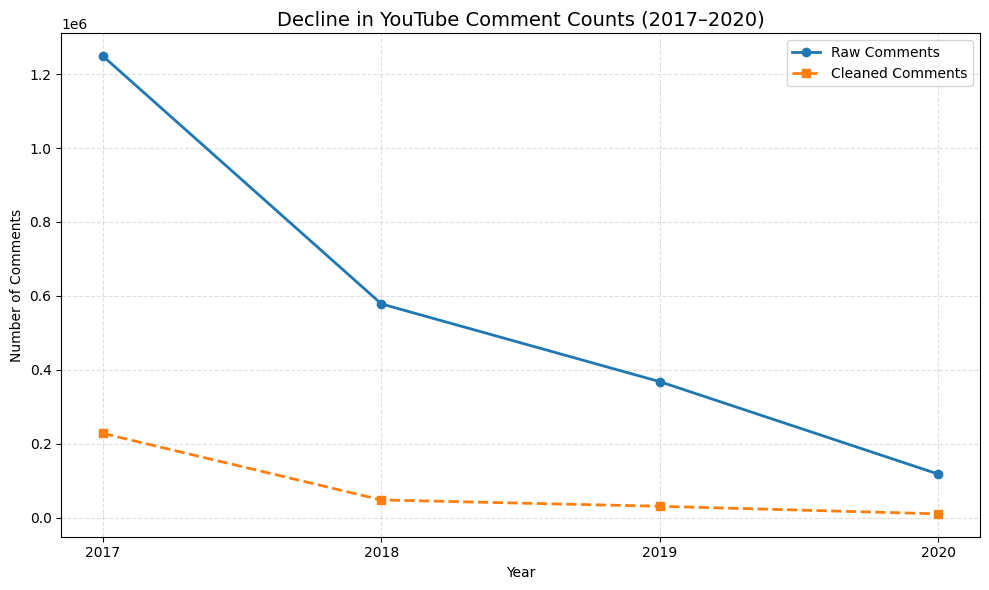

In [1]:
import matplotlib.pyplot as plt

# --- Data ---
years = [2017, 2018, 2019, 2020]

raw_counts = [1248291, 578324, 368078, 118176]
cleaned_counts = [228153, 48250, 31088, 10651]

# --- Plot Setup ---
plt.figure(figsize=(10, 6))
plt.plot(years, raw_counts, marker='o', label='Raw Comments', linewidth=2)
plt.plot(years, cleaned_counts, marker='s', label='Cleaned Comments', linewidth=2, linestyle='--')

# --- Decorations ---
plt.title("Decline in YouTube Comment Counts (2017–2020)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.xticks(years)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()

# --- Show Plot ---
plt.show()
